In [33]:
import re
import random
import pandas as pd
import hashlib

In [34]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Django', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [35]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(sum_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"The Mines of the Behemoth, Shea",112.637708,2.298729,16.025341,49
Asynchronous Python,162.542263,81.271132,94.312527,2
Exchange Online and Defender,280.196825,7.184534,18.353459,39
Docker,360.564241,11.631105,19.241786,31
"The Starless Crown, Rollins",373.670132,93.417533,113.901299,4
SSH + SCP,396.772802,13.681821,28.991626,29
GUI Docker Container,517.072782,24.622513,40.613893,21
"Everything is Tuberculosis, Green",651.586737,28.329858,44.086068,23
WinHex,657.780781,31.322894,47.931678,21
Linux,858.936754,26.841774,45.105778,32


# Histogram

sum of ages: ~53952.82


<Axes: >

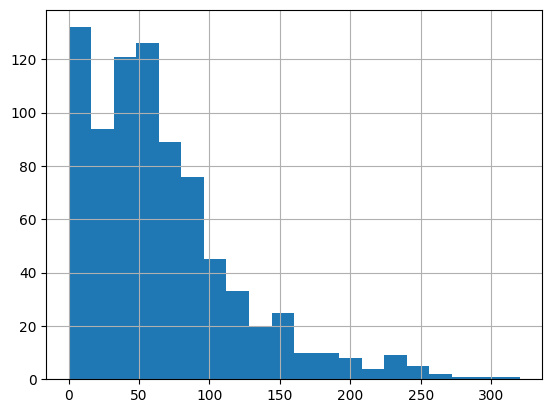

In [36]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53952.82


<Axes: >

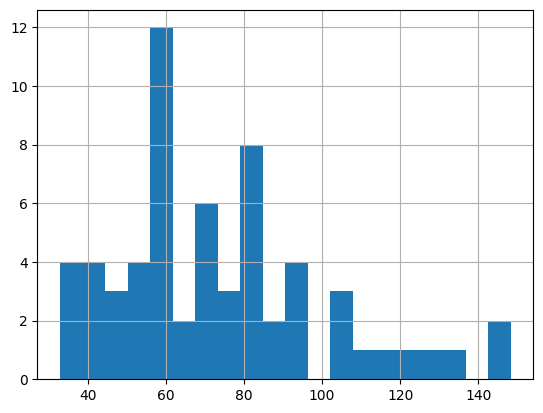

In [37]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [38]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [39]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [40]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [41]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [42]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [43]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

floor dividing for n-fold
Cards found: 812
Total card age: 53952.82


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
175,Asynchronous Python,asyncio.CancelledError\nAn exception in Python...,946c816b49002387f5ed3ccc128e9dbb,94.312527,81.271132,-94.312527,162.542263,0.561941,2,0,0,-94.312527
176,Asynchronous Python,Thread\nA thread is an independent sequence of...,fcb1e244bdfbde8641c39f7a41ad895a,68.229736,81.271132,-94.312527,162.542263,0.561941,2,1,0,-68.229736
150,"The Starless Crown, Rollins",Verdigris (VUR-duh-greess)\nnoun\nA greenish p...,0d43e5efc43a908a85de1f046b577179,113.901299,93.417533,-113.901299,373.670132,0.792163,4,0,0,-113.901299
151,"The Starless Crown, Rollins",Habiliment (huh-BIL-ih-ment)\nnoun\nClothing o...,a8bcf448141682d2b6175e87d3e3a754,98.094729,93.417533,-113.901299,373.670132,0.792163,4,1,0,-98.094729
152,"The Starless Crown, Rollins",Stanchion (STAN-shun)\nnoun\nAn upright post o...,957ff4a0359d53b5d4121f5658aae6c1,86.892065,93.417533,-113.901299,373.670132,0.792163,4,2,0,-86.892065
153,"The Starless Crown, Rollins",Bole of a tree (bohl)\n\nThe trunk or main ste...,252c0e92f6ee5a0e708fbc2118274c9d,74.782039,93.417533,-113.901299,373.670132,0.792163,4,3,0,-74.782039
108,PnP PowerShell,Invoke-PnPRequest (PnP.PowerShell)\nSends cust...,76b6b1815c89739010ffb02cb0d2d6fd,320.210058,157.736226,-320.210058,1104.153585,0.323639,7,0,0,-320.210058
109,PnP PowerShell,ConvertTo-SecureString (Microsoft.PowerShell.S...,591f14b66315e6cf38d09a9380a40a7c,226.022136,157.736226,-320.210058,1104.153585,0.323639,7,1,0,-226.022136
110,PnP PowerShell,Throttling in SharePoint\nLimits the number of...,ce09a5e40f02da64403e648d374270f5,139.931470,157.736226,-320.210058,1104.153585,0.323639,7,2,0,-139.931470
111,PnP PowerShell,Add-PnPField (PnP.PowerShell)\nAdds a new fiel...,63788258f43015c21266b6880c3934fc,129.937554,157.736226,-320.210058,1104.153585,0.323639,7,3,0,-129.937554



## Random

In [44]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [45]:
existing_cards.head(10)['age'].sum()

np.float64(1352.3136132132427)

In [46]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
108,PnP PowerShell,Invoke-PnPRequest (PnP.PowerShell)\nSends cust...,76b6b1815c89739010ffb02cb0d2d6fd,320.210058,157.736226,-320.210058,1104.153585,0.323639,7,0,0,-320.210058
3,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,299.440607,99.681606,-299.440607,4086.945856,0.788150,41,0,0,-299.440607
31,Django,Django App\nA self-contained feature module (e...,369de91dbb3f2242f251cc46ac43faac,279.634168,92.031772,-279.634168,3681.270863,0.239016,40,0,0,-279.634168
101,Accounting,General Ledger (GL)\nCentral accounting record...,2e1cb1792a872ef7c0655341a20c8431,266.784001,88.477827,-266.784001,1150.211749,0.221079,13,0,0,-266.784001
10,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,263.051569,90.229466,-263.051569,4060.325973,0.591287,45,0,0,-263.051569
80,TSQL,Q: What does SUM(x) OVER (PARTITION BY y) do?\...,dda5b7601f3b5593f784810dd25436e7,249.653980,100.500359,-249.653980,1608.005743,0.064017,16,0,0,-249.653980
24,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,248.119267,105.034834,-248.119267,3781.254033,0.499043,36,0,0,-248.119267
11,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,247.643813,90.229466,-263.051569,4060.325973,0.591287,45,1,0,-247.643813
25,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,242.883050,105.034834,-248.119267,3781.254033,0.499043,36,1,0,-242.883050
4,Node.js and Vite,Dependency Tree\nThe hierarchy of packages you...,fe8e79ae405e0d649b489d1c407e8f9e,240.788566,99.681606,-299.440607,4086.945856,0.788150,41,1,0,-240.788566


In [47]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 66.444'